Lifetime value prediction using online retain dataset (https://www.kaggle.com/vijayuv/onlineretail?select=OnlineRetail.csv)

Customer lifetime value is the total worth to business of a customer over the whole period of their relationship.CLTV helps companies to focus on those potential customers who can bring in the more revenue in the future.

    CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin

Definition:
- Average order value is the ratio of total revenue and total number of orders. It represents mean amount of revenue that the customer spends on an order 
- Purchase frequency is the ratio of the total number of orders and total number of customers. It represents the average number of orders placed by each customer 
- Churn rate is the percentage of customers who have not ordered again 
- Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain

Steps involved:
- Define an appropriate time frame for Customer lifetime value calculation
- Identify features we are going to use to predict future and create them
- Calculate lifetime value (LTV) to train the model
- Make predictions

Time frame for CLV calculation depends on the industry, business model, customer buying cycle, etc.  For this exercise, we will choose 6 months as time frame 

Features to predict customer lifetime value can be recency, frequency and monetary value scores for each customer. Customers with the lowest recency, highest frequency and monetary amounts considered as top customers.



Definition:

Recency (R): Who have purchased recently? Calculate the number of days between present date and date of last purchase each customer.

Frequency (F): Who has purchased frequently? Calculate the number of orders for each customer.

Monetary Value(M): Who has high purchase amount? Calculate sum of purchase price for each customer.

In [241]:
#import modules
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, f1_score,accuracy_score
from xgboost import XGBClassifier

In [242]:
#Download dataset
data = pd.read_csv('data/OnlineRetail.csv',encoding= 'unicode_escape')

In [243]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [244]:
#Remove duplicates based on above dataframe
filtered_data=data[['Country','CustomerID']].drop_duplicates()

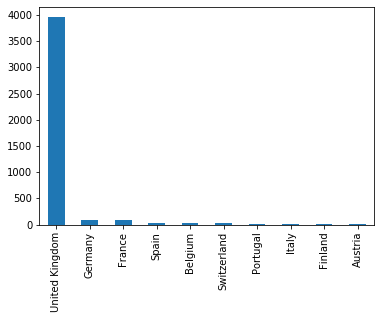

In [245]:
#Count number of customers by country 
filtered_data.Country.value_counts()[:10].plot(kind='bar')

In [246]:
#Since most of the customers are from UK, we will filter and work on just UK data 
uk_data=data[(data.Country=='United Kingdom')&(data.InvoiceDate>='2011-01-01')] 
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,240998.000000,240998.000000,180105.000000
mean,9.149063,4.450502,15521.004325
std,58.251835,105.717448,1587.330330
min,-9600.000000,-11062.060000,12747.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.080000,15492.000000
75%,10.000000,4.130000,16904.000000
max,4300.000000,38970.000000,18287.000000


In [247]:
#Some of the customers have negative orders who is not possible. We will apply another filter to choose quantity>0 
uk_data=uk_data[(uk_data['Quantity']>0)] 
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,236079.000000,236079.000000,176137.000000
mean,10.109493,3.703598,15525.069974
std,39.886699,47.099207,1586.495187
min,1.000000,-11062.060000,12747.000000
25%,1.000000,1.250000,14206.000000
50%,3.000000,2.080000,15493.000000
75%,10.000000,4.130000,16904.000000
max,4300.000000,11062.060000,18287.000000


In [248]:
#Filter required columns to calculate CLTV - CustomerID,InvoiceDate,InvoiceNo,Quantity and UnitPrice 
uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
105335,14620.0,3/1/2011 8:30,545220,2,7.95
105336,14620.0,3/1/2011 8:30,545220,2,7.95
105337,14620.0,3/1/2011 8:30,545220,12,1.65
105338,14620.0,3/1/2011 8:30,545220,3,4.95
105339,14620.0,3/1/2011 8:30,545220,4,3.75


In [249]:
#Calculate total purchase 
uk_data['TotalPurchase']=uk_data['Quantity']*uk_data['UnitPrice'] 
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase
105335,14620.0,3/1/2011 8:30,545220,2,7.95,15.90
105336,14620.0,3/1/2011 8:30,545220,2,7.95,15.90
105337,14620.0,3/1/2011 8:30,545220,12,1.65,19.80
105338,14620.0,3/1/2011 8:30,545220,3,4.95,14.85
105339,14620.0,3/1/2011 8:30,545220,4,3.75,15.00


In [250]:
uk_data['InvoiceDate']=pd.to_datetime(uk_data['InvoiceDate'], dayfirst=True)

In [251]:
#Calculate recency, frequency and monetary value for each customer 
uk_data_group=uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPurchase': lambda price: price.sum()})

uk_data_group.head()

,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12747.0,230,50,561,1760.09
12748.0,335,1594,10227,14680.85
12749.0,270,128,1080,2755.23
12820.0,0,14,217,217.77
12821.0,0,6,70,92.72


In [252]:
#Rename columns with meaningful names
uk_data_group.columns=['recency','num_transactions','frequency','monetary']
uk_data_group.head()


,recency,num_transactions,frequency,monetary
CustomerID,,,,
12747.0,230,50,561,1760.09
12748.0,335,1594,10227,14680.85
12749.0,270,128,1080,2755.23
12820.0,0,14,217,217.77
12821.0,0,6,70,92.72


In [253]:
#Calculate CLTV using above mentioned formula 
#Average Order Value 
uk_data_group['avg_order_value']=uk_data_group['monetary']/uk_data_group['num_transactions']
uk_data_group.head()

,recency,num_transactions,frequency,monetary,avg_order_value
CustomerID,,,,,
12747.0,230,50,561,1760.09,35.201800
12748.0,335,1594,10227,14680.85,9.210069
12749.0,270,128,1080,2755.23,21.525234
12820.0,0,14,217,217.77,15.555000
12821.0,0,6,70,92.72,15.453333


In [254]:
#Calculate purchase frequency 
purchase_frequency=sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]
print("Purchase frequency:",purchase_frequency)

Purchase frequency: 61.500349162011176


In [255]:
#Calculate repeat rate and churn rate 
repeat_rate=uk_data_group[uk_data_group.num_transactions > 1].shape[0]/uk_data_group.shape[0] 
churn_rate=1-repeat_rate 
print("Repeat rate:",repeat_rate) 
print("Churn rate:", churn_rate)

Repeat rate: 0.9804469273743017
Churn rate: 0.019553072625698276


In [256]:
#Calculate profit margin 
uk_data_group['profit_margin']=uk_data_group['monetary']*0.05

In [257]:
uk_data_group.head()

,recency,num_transactions,frequency,monetary,avg_order_value,profit_margin
CustomerID,,,,,,
12747.0,230,50,561,1760.09,35.201800,88.0045
12748.0,335,1594,10227,14680.85,9.210069,734.0425
12749.0,270,128,1080,2755.23,21.525234,137.7615
12820.0,0,14,217,217.77,15.555000,10.8885
12821.0,0,6,70,92.72,15.453333,4.6360


In [258]:
#Calculate Customer Lifetime Value for all customer IDs 
#Customer value
uk_data_group['CLV']=(uk_data_group['avg_order_value']*purchase_frequency)/churn_rate
#CUstomer lifetime value = CLV*profit margin
uk_data_group['cust_lifetime_value']=uk_data_group['CLV']*uk_data_group['profit_margin']


In [259]:
uk_data_group.head()

,recency,num_transactions,frequency,monetary,avg_order_value,profit_margin,CLV,cust_lifetime_value
CustomerID,,,,,,,,
12747.0,230,50,561,1760.09,35.201800,88.0045,110720.347261,9.743889e+06
12748.0,335,1594,10227,14680.85,9.210069,734.0425,28968.462946,2.126408e+07
12749.0,270,128,1080,2755.23,21.525234,137.7615,67703.396556,9.326921e+06
12820.0,0,14,217,217.77,15.555000,10.8885,48925.197054,5.327220e+05
12821.0,0,6,70,92.72,15.453333,4.6360,48605.424524,2.253347e+05


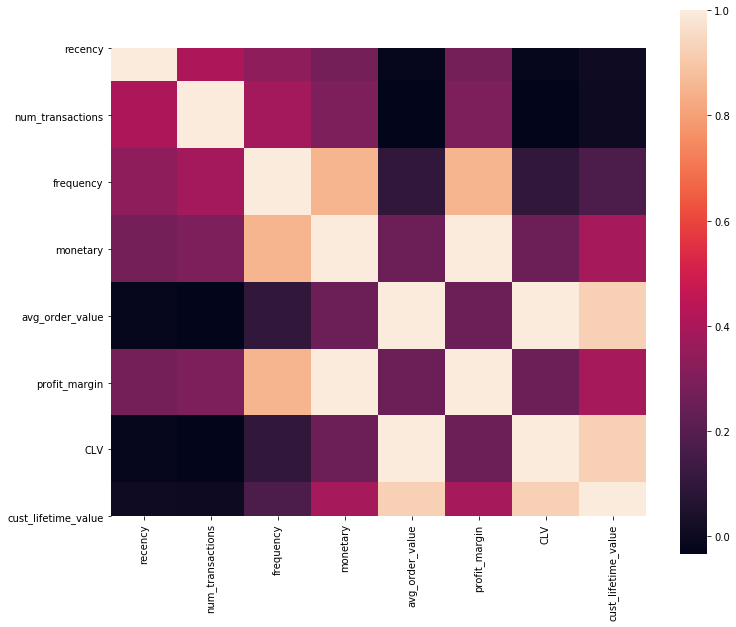

In [260]:
#Analyze correlations
corr=uk_data_group.corr() 
plt.subplots(figsize=(12,10))
sns.heatmap(corr,square=True)

In [261]:
uk_data_group.reset_index() 


,CustomerID,recency,num_transactions,frequency,monetary,avg_order_value,profit_margin,CLV,cust_lifetime_value
0,12747.0,230,50,561,1760.09,35.201800,88.0045,110720.347261,9.743889e+06
1,12748.0,335,1594,10227,14680.85,9.210069,734.0425,28968.462946,2.126408e+07
2,12749.0,270,128,1080,2755.23,21.525234,137.7615,67703.396556,9.326921e+06
3,12820.0,0,14,217,217.77,15.555000,10.8885,48925.197054,5.327220e+05
4,12821.0,0,6,70,92.72,15.453333,4.6360,48605.424524,2.253347e+05
...,...,...,...,...,...,...,...,...,...
2859,18280.0,0,10,45,180.60,18.060000,9.0300,56804.182500,5.129418e+05
2860,18281.0,0,7,54,80.82,11.545714,4.0410,36314.776378,1.467480e+05
2861,18282.0,0,7,75,100.21,14.315714,5.0105,45027.267270,2.256091e+05
2862,18283.0,83,315,555,802.77,2.548476,40.1385,8015.731264,3.217394e+05


In [262]:
#Create clusters of customers based on customer lifetime value 
kmeans=KMeans(n_clusters=3) 
kmeans.fit(uk_data_group[['cust_lifetime_value']]) 
uk_data_group['CLTV Cluster']=kmeans.predict(uk_data_group[['cust_lifetime_value']]) 
uk_data_group.groupby('CLTV Cluster')['cust_lifetime_value'].describe()

,count,mean,std,min,25%,50%,75%,max
CLTV Cluster,,,,,,,,
0,2859.0,1.216644e+07,9.429934e+07,6.613001e+02,5.733158e+05,1.464650e+06,4.152034e+06,2.737201e+09
1,1.0,8.352495e+10,NaN,8.352495e+10,8.352495e+10,8.352495e+10,8.352495e+10,8.352495e+10
2,4.0,1.331435e+10,4.198363e+09,7.297646e+09,1.255414e+10,1.444703e+10,1.520724e+10,1.706568e+10


In [263]:
#split train and test data 
X=uk_data_group.drop(['CLTV Cluster','cust_lifetime_value'],axis=1) 
y=uk_data_group['CLTV Cluster'] 

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X.head()

,recency,num_transactions,frequency,monetary,avg_order_value,profit_margin,CLV
CustomerID,,,,,,,
12747.0,230,50,561,1760.09,35.201800,88.0045,110720.347261
12748.0,335,1594,10227,14680.85,9.210069,734.0425,28968.462946
12749.0,270,128,1080,2755.23,21.525234,137.7615,67703.396556
12820.0,0,14,217,217.77,15.555000,10.8885,48925.197054
12821.0,0,6,70,92.72,15.453333,4.6360,48605.424524


In [265]:
#Build XGBoost model 
xgb_clf=XGBClassifier(max_depth=8, 
                                learning_rate=.1, 
                                n_estimators=100, 
                                gamma=0, 
                                min_child_weight=1, 
                                subsample=0.8).fit(X_train,y_train)
y_pred=xgb_clf.predict(X_test) 
print('Accuracy: '+xgb_clf.__class__.__name__, accuracy_score(y_test, y_pred))
print('AUC score: '+xgb_clf.__class__.__name__, roc_auc_score(y_test, y_pred)) 
print(classification_report(y_test, y_pred))

Accuracy: XGBClassifier 0.9947643979057592
AUC score: XGBClassifier 0.5
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       570
           2       0.00      0.00      0.00         3

    accuracy                           0.99       573
   macro avg       0.50      0.50      0.50       573
weighted avg       0.99      0.99      0.99       573



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
